# Training Stock Trading RL Agent using SAC and Deploying  as a Service

In [ ]:
import functools
import random
from collections import deque

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Concatenate, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import functools
from collections import deque

In [ ]:
tf.keras.backend.set_floatx("float64")

## Implementing the RL agent’s runtime components

In [ ]:
def actor(state_shape, action_shape, units=(512, 256, 64)):
    state_shape_flattened = functools.reduce(lambda x, y: x * y, state_shape)
    state = Input(shape=state_shape_flattened)
    x = Dense(units[0], name="L0", activation="relu")(state)
    for index in range(1, len(units)):
        x = Dense(units[index], name="L{}".format(index), activation="relu")(x)

    actions_mean = Dense(action_shape[0], name="Out_mean")(x)
    actions_std = Dense(action_shape[0], name="Out_std")(x)

    model = Model(inputs=state, outputs=[actions_mean, actions_std])

    return model

In [ ]:
def critic(state_shape, action_shape, units=(512, 256, 64)):
    state_shape_flattened = functools.reduce(lambda x, y: x * y, state_shape)
    inputs = [Input(shape=state_shape_flattened), Input(shape=action_shape)]
    concat = Concatenate(axis=-1)(inputs)
    x = Dense(units[0], name="Hidden0", activation="relu")(concat)
    for index in range(1, len(units)):
        x = Dense(units[index], name="Hidden{}".format(index), activation="relu")(x)

    output = Dense(1, name="Out_QVal")(x)
    model = Model(inputs=inputs, outputs=output)

    return model

In [ ]:
def update_target_weights(model, target_model, tau=0.005):
    weights = model.get_weights()
    target_weights = target_model.get_weights()
    for i in range(len(target_weights)):  # set tau% of target model to be new weights
        target_weights[i] = weights[i] * tau + target_weights[i] * (1 - tau)
    target_model.set_weights(target_weights)

In [ ]:
# class SAC(object):
#     def __init__(
#         self,
#         observation_shape,
#         action_space,
#         lr_actor=3e-5,
#         lr_critic=3e-4,
#         actor_units=(64, 64),
#         critic_units=(64, 64),
#         auto_alpha=True,
#         alpha=0.2,
#         tau=0.005,
#         gamma=0.99,
#         batch_size=128,
#         memory_cap=100000,
#     ):
#         self.state_shape = observation_shape  # shape of observations
#         self.action_shape = action_space.shape  # number of actions
#         self.action_bound = (action_space.high - action_space.low) / 2
#         self.action_shift = (action_space.high + action_space.low) / 2
#         self.memory = deque(maxlen=int(memory_cap))

#         # Define and initialize actor network
#         self.actor = actor(self.state_shape, self.action_shape, actor_units)
#         self.actor_optimizer = Adam(learning_rate=lr_actor)
#         self.log_std_min = -20
#         self.log_std_max = 2
#         print(self.actor.summary())

#         # Define and initialize critic networks
#         self.critic_1 = critic(self.state_shape, self.action_shape, critic_units)
#         self.critic_target_1 = critic(self.state_shape, self.action_shape, critic_units)
#         self.critic_optimizer_1 = Adam(learning_rate=lr_critic)
#         update_target_weights(self.critic_1, self.critic_target_1, tau=1.0)

#         self.critic_2 = critic(self.state_shape, self.action_shape, critic_units)
#         self.critic_target_2 = critic(self.state_shape, self.action_shape, critic_units)
#         self.critic_optimizer_2 = Adam(learning_rate=lr_critic)
#         update_target_weights(self.critic_2, self.critic_target_2, tau=1.0)

#         print(self.critic_1.summary())

#         # Define and initialize temperature alpha and target entropy
#         self.auto_alpha = auto_alpha
#         if auto_alpha:
#             self.target_entropy = -np.prod(self.action_shape)
#             self.log_alpha = tf.Variable(0.0, dtype=tf.float64)
#             self.alpha = tf.Variable(0.0, dtype=tf.float64)
#             self.alpha.assign(tf.exp(self.log_alpha))
#             self.alpha_optimizer = Adam(learning_rate=lr_actor)
#         else:
#             self.alpha = tf.Variable(alpha, dtype=tf.float64)

#         # Set hyperparameters
#         self.gamma = gamma  # discount factor
#         self.tau = tau  # target model update
#         self.batch_size = batch_size

#         # Tensorboard
#         self.summaries = {}

#     def process_actions(self, mean, log_std, test=False, eps=1e-6):
#         std = tf.math.exp(log_std)
#         raw_actions = mean

#         if not test:
#             raw_actions += tf.random.normal(shape=mean.shape, dtype=tf.float64) * std

#         log_prob_u = tfp.distributions.Normal(loc=mean, scale=std).log_prob(raw_actions)
#         actions = tf.math.tanh(raw_actions)

#         log_prob = tf.reduce_sum(log_prob_u - tf.math.log(1 - actions ** 2 + eps))

#         actions = actions * self.action_bound + self.action_shift

#         return actions, log_prob

#     def act(self, state, test=False, use_random=False):
#         state = state.reshape(-1)  # Flatten state
#         state = np.expand_dims(state, axis=0).astype(np.float64)

#         if use_random:
#             a = tf.random.uniform(
#                 shape=(1, self.action_shape[0]), minval=-1, maxval=1, dtype=tf.float64
#             )
#         else:
#             means, log_stds = self.actor.predict(state)
#             log_stds = tf.clip_by_value(log_stds, self.log_std_min, self.log_std_max)

#             a, log_prob = self.process_actions(means, log_stds, test=test)

#         q1 = self.critic_1.predict([state, a])[0][0]
#         q2 = self.critic_2.predict([state, a])[0][0]
#         self.summaries["q_min"] = tf.math.minimum(q1, q2)
#         self.summaries["q_mean"] = np.mean([q1, q2])

#         return a

#     def load_actor(self, a_fn):
#         self.actor.load_weights(a_fn)
#         print(self.actor.summary())

#     def load_critic(self, c_fn):
#         self.critic_1.load_weights(c_fn)
#         self.critic_target_1.load_weights(c_fn)
#         self.critic_2.load_weights(c_fn)
#         self.critic_target_2.load_weights(c_fn)
#         print(self.critic_1.summary())

we implemented the essential runtime components for the SAC agent. The runtime components include the actor and critic model definitions, a mechanism to load weights from previously trained agent models, and an agent interface to generate actions given states using the actor’s prediction and to process the prediction to generate an executable action.

The runtime components for other actor-critic-based RL agent algorithms, such as A2C, A3C, and DDPG, as well as their extensions and variants, will be very similar, if not the same.

SAC Agent Base

In [ ]:
class SAC(object):
    def __init__(
        self,
        observation_shape,
        action_space,
        lr_actor=3e-5,
        lr_critic=3e-4,
        actor_units=(64, 64),
        critic_units=(64, 64),
        auto_alpha=True,
        alpha=0.2,
        tau=0.005,
        gamma=0.99,
        batch_size=128,
        memory_cap=100000,
    ):
        self.state_shape = observation_shape  # shape of observations
        self.action_shape = action_space.shape  # number of actions
        self.action_bound = (action_space.high - action_space.low) / 2
        self.action_shift = (action_space.high + action_space.low) / 2
        self.memory = deque(maxlen=int(memory_cap))

        # Define and initialize actor network
        self.actor = actor(self.state_shape, self.action_shape, actor_units)
        self.actor_optimizer = Adam(learning_rate=lr_actor)
        self.log_std_min = -20
        self.log_std_max = 2
        print(self.actor.summary())

        # Define and initialize critic networks
        self.critic_1 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_target_1 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_optimizer_1 = Adam(learning_rate=lr_critic)
        update_target_weights(self.critic_1, self.critic_target_1, tau=1.0)

        self.critic_2 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_target_2 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_optimizer_2 = Adam(learning_rate=lr_critic)
        update_target_weights(self.critic_2, self.critic_target_2, tau=1.0)

        print(self.critic_1.summary())

        # Define and initialize temperature alpha and target entropy
        self.auto_alpha = auto_alpha
        if auto_alpha:
            self.target_entropy = -np.prod(self.action_shape)
            self.log_alpha = tf.Variable(0.0, dtype=tf.float64)
            self.alpha = tf.Variable(0.0, dtype=tf.float64)
            self.alpha.assign(tf.exp(self.log_alpha))
            self.alpha_optimizer = Adam(learning_rate=lr_actor)
        else:
            self.alpha = tf.Variable(alpha, dtype=tf.float64)

        # Set hyperparameters
        self.gamma = gamma  # discount factor
        self.tau = tau  # target model update
        self.batch_size = batch_size

        # Tensorboard
        self.summaries = {}

    def process_actions(self, mean, log_std, test=False, eps=1e-6):
        std = tf.math.exp(log_std)
        raw_actions = mean

        if not test:
            raw_actions += tf.random.normal(shape=mean.shape, dtype=tf.float64) * std

        log_prob_u = tfp.distributions.Normal(loc=mean, scale=std).log_prob(raw_actions)
        actions = tf.math.tanh(raw_actions)

        log_prob = tf.reduce_sum(log_prob_u - tf.math.log(1 - actions ** 2 + eps))

        actions = actions * self.action_bound + self.action_shift

        return actions, log_prob

    def act(self, state, test=False, use_random=False):
        state = state.reshape(-1)  # Flatten state
        state = np.expand_dims(state, axis=0).astype(np.float64)

        if use_random and len(self.memory) > self.batch_size:
            a = tf.random.uniform(
                shape=(1, self.action_shape[0]), minval=-1, maxval=1, dtype=tf.float64
            )
        else:
            means, log_stds = self.actor.predict(state)
            log_stds = tf.clip_by_value(log_stds, self.log_std_min, self.log_std_max)

            a, log_prob = self.process_actions(means, log_stds, test=test)

        q1 = self.critic_1.predict([state, a])[0][0]
        q2 = self.critic_2.predict([state, a])[0][0]
        self.summaries["q_min"] = tf.math.minimum(q1, q2)
        self.summaries["q_mean"] = np.mean([q1, q2])

        return a

    def save_model(self, a_fn, c_fn):
        self.actor.save(a_fn)
        self.critic_1.save(c_fn)

    def load_actor(self, a_fn):
        self.actor.load_weights(a_fn)
        print(self.actor.summary())

    def load_critic(self, c_fn):
        self.critic_1.load_weights(c_fn)
        self.critic_target_1.load_weights(c_fn)
        self.critic_2.load_weights(c_fn)
        self.critic_target_2.load_weights(c_fn)
        print(self.critic_1.summary())

    def remember(self, state, action, reward, next_state, done):
        state = state.reshape(-1)  # Flatten state
        state = np.expand_dims(state, axis=0)
        next_state = next_state.reshape(-1)  # Flatten next-state
        next_state = np.expand_dims(next_state, axis=0)
        self.memory.append([state, action, reward, next_state, done])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        samples = random.sample(self.memory, self.batch_size)
        s = np.array(samples).T
        states, actions, rewards, next_states, dones = [
            np.vstack(s[i, :]).astype(np.float) for i in range(5)
        ]

        with tf.GradientTape(persistent=True) as tape:
            # next state action log probs
            means, log_stds = self.actor(next_states)
            log_stds = tf.clip_by_value(log_stds, self.log_std_min, self.log_std_max)
            next_actions, log_probs = self.process_actions(means, log_stds)

            # critics loss
            current_q_1 = self.critic_1([states, actions])
            current_q_2 = self.critic_2([states, actions])
            next_q_1 = self.critic_target_1([next_states, next_actions])
            next_q_2 = self.critic_target_2([next_states, next_actions])
            next_q_min = tf.math.minimum(next_q_1, next_q_2)
            state_values = next_q_min - self.alpha * log_probs
            target_qs = tf.stop_gradient(
                rewards + state_values * self.gamma * (1.0 - dones)
            )
            critic_loss_1 = tf.reduce_mean(
                0.5 * tf.math.square(current_q_1 - target_qs)
            )
            critic_loss_2 = tf.reduce_mean(
                0.5 * tf.math.square(current_q_2 - target_qs)
            )

            # current state action log probs
            means, log_stds = self.actor(states)
            log_stds = tf.clip_by_value(log_stds, self.log_std_min, self.log_std_max)
            actions, log_probs = self.process_actions(means, log_stds)

            # actor loss
            current_q_1 = self.critic_1([states, actions])
            current_q_2 = self.critic_2([states, actions])
            current_q_min = tf.math.minimum(current_q_1, current_q_2)
            actor_loss = tf.reduce_mean(self.alpha * log_probs - current_q_min)

            # temperature loss
            if self.auto_alpha:
                alpha_loss = -tf.reduce_mean(
                    (self.log_alpha * tf.stop_gradient(log_probs + self.target_entropy))
                )

        critic_grad = tape.gradient(
            critic_loss_1, self.critic_1.trainable_variables
        )  # compute actor gradient
        self.critic_optimizer_1.apply_gradients(
            zip(critic_grad, self.critic_1.trainable_variables)
        )

        critic_grad = tape.gradient(
            critic_loss_2, self.critic_2.trainable_variables
        )  # compute actor gradient
        self.critic_optimizer_2.apply_gradients(
            zip(critic_grad, self.critic_2.trainable_variables)
        )

        actor_grad = tape.gradient(
            actor_loss, self.actor.trainable_variables
        )  # compute actor gradient
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor.trainable_variables)
        )

        # tensorboard info
        self.summaries["q1_loss"] = critic_loss_1
        self.summaries["q2_loss"] = critic_loss_2
        self.summaries["actor_loss"] = actor_loss

        if self.auto_alpha:
            # optimize temperature
            alpha_grad = tape.gradient(alpha_loss, [self.log_alpha])
            self.alpha_optimizer.apply_gradients(zip(alpha_grad, [self.log_alpha]))
            self.alpha.assign(tf.exp(self.log_alpha))
            # tensorboard info
            self.summaries["alpha_loss"] = alpha_loss

    def train(self, cur_state, action, reward, next_state, done):
        self.remember(cur_state, action, reward, next_state, done)  # add to memory
        self.replay()  # train models through memory replay
        update_target_weights(
            self.critic_1, self.critic_target_1, tau=self.tau
        )  # iterates target model
        update_target_weights(self.critic_2, self.critic_target_2, tau=self.tau)

    def update_memory(self, xp_store):
        for (cur_state, action, reward, next_state, done) in zip(
            xp_store["cur_states"],
            xp_store["actions"],
            xp_store["rewards"],
            xp_store["next_states"],
            xp_store["dones"],
        ):
            self.remember(cur_state, action, reward, next_state, done)  # add to memory

    def train_with_distributed_replay_memory(self, new_experiences):
        self.update_memory(new_experiences)
        self.replay()  # train models through memory replay
        update_target_weights(
            self.critic_1, self.critic_target_1, tau=self.tau
        )  # iterates target model
        update_target_weights(self.critic_2, self.critic_target_2, tau=self.tau)

    def log_status(self, summary_writer, episode_num, reward):
        """Write training stats using TF `summary_writer`"""
        with summary_writer.as_default():
            if len(self.memory) > self.batch_size:
                tf.summary.scalar(
                    "Loss/actor_loss", self.summaries["actor_loss"], step=episode_num
                )
                tf.summary.scalar(
                    "Loss/q1_loss", self.summaries["q1_loss"], step=episode_num
                )
                tf.summary.scalar(
                    "Loss/q2_loss", self.summaries["q2_loss"], step=episode_num
                )
                if self.auto_alpha:
                    tf.summary.scalar(
                        "Loss/alpha_loss",
                        self.summaries["alpha_loss"],
                        step=episode_num,
                    )

            tf.summary.scalar("Stats/alpha", self.alpha, step=episode_num)
            if self.auto_alpha:
                tf.summary.scalar("Stats/log_alpha", self.log_alpha, step=episode_num)
            tf.summary.scalar("Stats/q_min", self.summaries["q_min"], step=episode_num)
            tf.summary.scalar(
                "Stats/q_mean", self.summaries["q_mean"], step=episode_num
            )
            tf.summary.scalar("Main/step_reward", reward, step=episode_num)

## Building RL environment simulators as a service

Our implementation will contain two core modules – the tradegym server and the tradegym client, which are built based on the OpenAI Gym HTTP API. The recipe will focus on the customizations and the core components of the HTTP service interface. We will first define a minimum set of custom environments exposed as part of the tradegym library and then build the server and client modules.

In [ ]:
!pip install -U flask

In [ ]:
!wget -q --show-progress https://github.com/RecoHut-Projects/drl-recsys/raw/S990517/tools/tradegym.zip
!unzip tradegym.zip

In [ ]:
%%writefile tradegym_server.py
import argparse
import json
import logging
import os
import sys
import uuid

import numpy as np
import six
from flask import Flask, jsonify, request

import gym
import tradegym


logger = logging.getLogger("tradegym")
logger.setLevel(logging.ERROR)


########## Container for environments ##########
class Envs(object):
    """
    Container and manager for the environments instantiated
    on this server.
    When a new environment is created, such as with
    envs.create('CartPole-v0'), it is stored under a short
    identifier (such as '3c657dbc'). Future API calls make
    use of this instance_id to identify which environment
    should be manipulated.
    """

    def __init__(self):
        self.envs = {}
        self.id_len = 8

    def _lookup_env(self, instance_id):
        try:
            return self.envs[instance_id]
        except KeyError:
            raise InvalidUsage("Instance_id {} unknown".format(instance_id))

    def _remove_env(self, instance_id):
        try:
            del self.envs[instance_id]
        except KeyError:
            raise InvalidUsage("Instance_id {} unknown".format(instance_id))

    def create(self, env_id, seed=None):
        try:
            env = gym.make(env_id)
            if seed:
                env.seed(seed)
        except gym.error.Error:
            raise InvalidUsage(
                "Attempted to look up malformed environment ID '{}'".format(env_id)
            )

        instance_id = str(uuid.uuid4().hex)[: self.id_len]
        self.envs[instance_id] = env
        return instance_id

    def list_all(self):
        return dict(
            [(instance_id, env.spec.id) for (instance_id, env) in self.envs.items()]
        )

    def reset(self, instance_id):
        env = self._lookup_env(instance_id)
        obs = env.reset()
        return env.observation_space.to_jsonable(obs)

    def step(self, instance_id, action, render):
        env = self._lookup_env(instance_id)
        if isinstance(action, six.integer_types):
            nice_action = action
        else:
            nice_action = np.array(action)
        if render:
            env.render()
        [observation, reward, done, info] = env.step(nice_action)
        obs_jsonable = env.observation_space.to_jsonable(observation)
        return [obs_jsonable, reward, done, info]

    def get_action_space_contains(self, instance_id, x):
        env = self._lookup_env(instance_id)
        return env.action_space.contains(int(x))

    def get_action_space_info(self, instance_id):
        env = self._lookup_env(instance_id)
        return self._get_space_properties(env.action_space)

    def get_action_space_sample(self, instance_id):
        env = self._lookup_env(instance_id)
        action = env.action_space.sample()
        if isinstance(action, (list, tuple)) or ("numpy" in str(type(action))):
            try:
                action = action.tolist()
            except TypeError:
                print(type(action))
                print("TypeError")
        return action

    def get_observation_space_contains(self, instance_id, j):
        env = self._lookup_env(instance_id)
        info = self._get_space_properties(env.observation_space)
        for key, value in j.items():
            # Convert both values to json for comparibility
            if json.dumps(info[key]) != json.dumps(value):
                print(
                    'Values for "{}" do not match. Passed "{}", Observed "{}".'.format(
                        key, value, info[key]
                    )
                )
                return False
        return True

    def get_observation_space_info(self, instance_id):
        env = self._lookup_env(instance_id)
        return self._get_space_properties(env.observation_space)

    def _get_space_properties(self, space):
        info = {}
        info["name"] = space.__class__.__name__
        if info["name"] == "Discrete":
            info["n"] = space.n
        elif info["name"] == "Box":
            info["shape"] = space.shape
            # It's not JSON compliant to have Infinity, -Infinity, NaN.
            # Many newer JSON parsers allow it, but many don't. Notably python json
            # module can read and write such floats. So we only here fix "export version",
            # also make it flat.
            info["low"] = [
                (x if x != -np.inf else -1e100) for x in np.array(space.low).flatten()
            ]
            info["high"] = [
                (x if x != +np.inf else +1e100) for x in np.array(space.high).flatten()
            ]
        elif info["name"] == "HighLow":
            info["num_rows"] = space.num_rows
            info["matrix"] = [
                ((float(x) if x != -np.inf else -1e100) if x != +np.inf else +1e100)
                for x in np.array(space.matrix).flatten()
            ]
        return info

    def monitor_start(self, instance_id, directory, force, resume, video_callable):
        env = self._lookup_env(instance_id)
        if video_callable == False:
            v_c = lambda count: False
        else:
            v_c = lambda count: count % video_callable == 0
        self.envs[instance_id] = gym.wrappers.Monitor(
            env, directory, force=force, resume=resume, video_callable=v_c
        )

    def monitor_close(self, instance_id):
        env = self._lookup_env(instance_id)
        env.close()

    def env_close(self, instance_id):
        env = self._lookup_env(instance_id)
        env.close()
        self._remove_env(instance_id)


app = Flask(__name__)
app.config["JSONIFY_PRETTYPRINT_REGULAR"] = False
envs = Envs()


class InvalidUsage(Exception):
    status_code = 400

    def __init__(self, message, status_code=None, payload=None):
        Exception.__init__(self)
        self.message = message
        if status_code is not None:
            self.status_code = status_code
        self.payload = payload

    def to_dict(self):
        rv = dict(self.payload or ())
        rv["message"] = self.message
        return rv


def get_required_param(json, param):
    if json is None:
        logger.info("Request is not a valid json")
        raise InvalidUsage("Request is not a valid json")
    value = json.get(param, None)
    if (value is None) or (value == "") or (value == []):
        logger.info(
            "A required request parameter '{}' had value {}".format(param, value)
        )
        raise InvalidUsage(
            "A required request parameter '{}' was not provided".format(param)
        )
    return value


def get_optional_param(json, param, default):
    if json is None:
        logger.info("Request is not a valid json")
        raise InvalidUsage("Request is not a valid json")
    value = json.get(param, None)
    if (value is None) or (value == "") or (value == []):
        logger.info(
            "An optional request parameter '{}' had value {} and was replaced with default value {}".format(
                param, value, default
            )
        )
        value = default
    return value


@app.errorhandler(InvalidUsage)
def handle_invalid_usage(error):
    response = jsonify(error.to_dict())
    response.status_code = error.status_code
    return response


########## API route definitions ##########
@app.route("/v1/envs/", methods=["POST"])
def env_create():
    """
    Create an instance of the specified environment
    Parameters:
        - env_id: gym environment ID string, such as 'CartPole-v0'
        - seed: set the seed for this env's random number generator(s).
    Returns:
        - instance_id: a short identifier (such as '3c657dbc')
        for the created environment instance. The instance_id is
        used in future API calls to identify the environment to be
        manipulated
    """
    env_id = get_required_param(request.get_json(), "env_id")
    seed = get_optional_param(request.get_json(), "seed", None)
    instance_id = envs.create(env_id, seed)
    return jsonify(instance_id=instance_id)


@app.route("/v1/envs/", methods=["GET"])
def env_list_all():
    """
    List all environments running on the server
    Returns:
        - envs: dict mapping instance_id to env_id
        (e.g. {'3c657dbc': 'CartPole-v0'}) for every env
        on the server
    """
    all_envs = envs.list_all()
    return jsonify(all_envs=all_envs)


@app.route("/v1/envs/<instance_id>/reset/", methods=["POST"])
def env_reset(instance_id):
    """
    Reset the state of the environment and return an initial
    observation.
    Parameters:
        - instance_id: a short identifier (such as '3c657dbc')
        for the environment instance
    Returns:
        - observation: the initial observation of the space
    """
    observation = envs.reset(instance_id)
    if np.isscalar(observation):
        observation = observation.item()
    return jsonify(observation=observation)


@app.route("/v1/envs/<instance_id>/step/", methods=["POST"])
def env_step(instance_id):
    """
    Run one timestep of the environment's dynamics.
    Parameters:
        - instance_id: a short identifier (such as '3c657dbc')
        for the environment instance
        - action: an action to take in the environment
    Returns:
        - observation: agent's observation of the current
        environment
        - reward: amount of reward returned after previous action
        - done: whether the episode has ended
        - info: a dict containing auxiliary diagnostic information
    """
    json = request.get_json()
    action = get_required_param(json, "action")
    render = get_optional_param(json, "render", False)
    [obs_jsonable, reward, done, info] = envs.step(instance_id, action, render)
    return jsonify(observation=obs_jsonable, reward=reward, done=done, info=info)


@app.route("/v1/envs/<instance_id>/action_space/", methods=["GET"])
def env_action_space_info(instance_id):
    """
    Get information (name and dimensions/bounds) of the env's
    action_space
    Parameters:
        - instance_id: a short identifier (such as '3c657dbc')
        for the environment instance
    Returns:
    - info: a dict containing 'name' (such as 'Discrete'), and
    additional dimensional info (such as 'n') which varies from
    space to space
    """
    info = envs.get_action_space_info(instance_id)
    return jsonify(info=info)


@app.route("/v1/envs/<instance_id>/action_space/sample", methods=["GET"])
def env_action_space_sample(instance_id):
    """
    Get a sample from the env's action_space
    Parameters:
        - instance_id: a short identifier (such as '3c657dbc')
        for the environment instance
    Returns:
        - action: a randomly sampled element belonging to the action_space
    """
    action = envs.get_action_space_sample(instance_id)
    return jsonify(action=action)


@app.route("/v1/envs/<instance_id>/action_space/contains/<x>", methods=["GET"])
def env_action_space_contains(instance_id, x):
    """
    Assess that value is a member of the env's action_space
    Parameters:
        - instance_id: a short identifier (such as '3c657dbc')
        for the environment instance
            - x: the value to be checked as member
    Returns:
        - member: whether the value passed as parameter belongs to the action_space
    """

    member = envs.get_action_space_contains(instance_id, x)
    return jsonify(member=member)


@app.route("/v1/envs/<instance_id>/observation_space/contains", methods=["POST"])
def env_observation_space_contains(instance_id):
    """
    Assess that the parameters are members of the env's observation_space
    Parameters:
        - instance_id: a short identifier (such as '3c657dbc')
        for the environment instance
    Returns:
        - member: whether all the values passed belong to the observation_space
    """
    j = request.get_json()
    member = envs.get_observation_space_contains(instance_id, j)
    return jsonify(member=member)


@app.route("/v1/envs/<instance_id>/observation_space/", methods=["GET"])
def env_observation_space_info(instance_id):
    """
    Get information (name and dimensions/bounds) of the env's
    observation_space
    Parameters:
        - instance_id: a short identifier (such as '3c657dbc')
        for the environment instance
    Returns:
        - info: a dict containing 'name' (such as 'Discrete'),
        and additional dimensional info (such as 'n') which
        varies from space to space
    """
    info = envs.get_observation_space_info(instance_id)
    return jsonify(info=info)


@app.route("/v1/envs/<instance_id>/monitor/start/", methods=["POST"])
def env_monitor_start(instance_id):
    """
    Start monitoring.
    Parameters:
        - instance_id: a short identifier (such as '3c657dbc')
        for the environment instance
        - force (default=False): Clear out existing training
        data from this directory (by deleting every file
        prefixed with "openaigym.")
        - resume (default=False): Retain the training data
        already in this directory, which will be merged with
        our new data
    """
    j = request.get_json()

    directory = get_required_param(j, "directory")
    force = get_optional_param(j, "force", False)
    resume = get_optional_param(j, "resume", False)
    video_callable = get_optional_param(j, "video_callable", False)
    envs.monitor_start(instance_id, directory, force, resume, video_callable)
    return ("", 204)


@app.route("/v1/envs/<instance_id>/monitor/close/", methods=["POST"])
def env_monitor_close(instance_id):
    """
    Flush all monitor data to disk.
    Parameters:
        - instance_id: a short identifier (such as '3c657dbc')
          for the environment instance
    """
    envs.monitor_close(instance_id)
    return ("", 204)


@app.route("/v1/envs/<instance_id>/close/", methods=["POST"])
def env_close(instance_id):
    """
    Manually close an environment
    Parameters:
        - instance_id: a short identifier (such as '3c657dbc')
          for the environment instance
    """
    envs.env_close(instance_id)
    return ("", 204)


@app.route("/v1/upload/", methods=["POST"])
def upload():
    """
    Upload the results of training (as automatically recorded by
    your env's monitor) to OpenAI Gym.
    Parameters:
        - training_dir: A directory containing the results of a
        training run.
        - api_key: Your OpenAI API key
        - algorithm_id (default=None): An arbitrary string
        indicating the paricular version of the algorithm
        (including choices of parameters) you are running.
    """
    j = request.get_json()
    training_dir = get_required_param(j, "training_dir")
    api_key = get_required_param(j, "api_key")
    algorithm_id = get_optional_param(j, "algorithm_id", None)

    try:
        gym.upload(
            training_dir,
            algorithm_id,
            writeup=None,
            api_key=api_key,
            ignore_open_monitors=False,
        )
        return ("", 204)
    except gym.error.AuthenticationError:
        raise InvalidUsage("You must provide an OpenAI Gym API key")


@app.route("/v1/shutdown/", methods=["POST"])
def shutdown():
    """ Request a server shutdown - currently used by the integration tests to repeatedly create and destroy fresh copies of the server running in a separate thread"""
    f = request.environ.get("werkzeug.server.shutdown")
    f()
    return "Server shutting down"


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Start a Gym HTTP API server")
    parser.add_argument(
        "-l", "--listen", help="interface to listen to", default="0.0.0.0"
    )
    parser.add_argument("-p", "--port", default=6666, type=int, help="port to bind to")

    args = parser.parse_args()
    print("Server starting at: " + "http://{}:{}".format(args.listen, args.port))
    app.run(host=args.listen, port=args.port, debug=True)

Writing tradegym_server.py


In [ ]:
!sudo nohup python tradegym_server.py > log.txt 2>&1 &

In [ ]:
!head log.txt

 * Running on http://0.0.0.0:6666/ (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 323-023-100


Client

In [ ]:
!pip install mplfinance

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
import sys
import requests
import json
import logging
import six.moves.urllib.parse as urlparse

import gym
import tradegym

In [ ]:
# host_ip = "0.0.0.0"
# host_port = 6666
# endpoint = "v1/act"
# env = gym.make("StockTradingContinuousEnv-v0")

In [ ]:
# Create an App-level child logger
logger = logging.getLogger("TFRL-tradegym-client")
# Set handler for this logger to handle messages
logger.addHandler(logging.StreamHandler())
# Set logging-level for this logger's handler
logger.setLevel(logging.DEBUG)

In [ ]:
class Client(object):
    """
    Gym client to interface with gym_http_server
    """

    def __init__(self, remote_base):
        self.remote_base = remote_base
        self.session = requests.Session()
        self.session.headers.update({"Content-type": "application/json"})

    def _parse_server_error_or_raise_for_status(self, resp):
        j = {}
        try:
            j = resp.json()
        except:
            # Most likely json parse failed because of network error, not server error (server
            # sends its errors in json). Don't let parse exception go up, but rather raise default
            # error.
            resp.raise_for_status()
        if (
            resp.status_code != 200 and "message" in j
        ):  # descriptive message from server side
            raise ServerError(message=j["message"], status_code=resp.status_code)
        resp.raise_for_status()
        return j

    def _post_request(self, route, data):
        url = urlparse.urljoin(self.remote_base, route)
        # logger.info("POST {}\n{}".format(url, json.dumps(data)))
        resp = self.session.post(
            urlparse.urljoin(self.remote_base, route), data=json.dumps(data)
        )
        return self._parse_server_error_or_raise_for_status(resp)

    def _get_request(self, route):
        url = urlparse.urljoin(self.remote_base, route)
        # logger.info("GET {}".format(url))
        resp = self.session.get(url)
        return self._parse_server_error_or_raise_for_status(resp)

    def env_create(self, env_id):
        route = "/v1/envs/"
        data = {"env_id": env_id}
        resp = self._post_request(route, data)
        instance_id = resp["instance_id"]
        return instance_id

    def env_list_all(self):
        route = "/v1/envs/"
        resp = self._get_request(route)
        all_envs = resp["all_envs"]
        return all_envs

    def env_reset(self, instance_id):
        route = "/v1/envs/{}/reset/".format(instance_id)
        resp = self._post_request(route, None)
        observation = resp["observation"]
        return observation

    def env_step(self, instance_id, action, render=False):
        route = "/v1/envs/{}/step/".format(instance_id)
        data = {"action": action, "render": render}
        resp = self._post_request(route, data)
        observation = resp["observation"]
        reward = resp["reward"]
        done = resp["done"]
        info = resp["info"]
        return [observation, reward, done, info]

    def env_action_space_info(self, instance_id):
        route = "/v1/envs/{}/action_space/".format(instance_id)
        resp = self._get_request(route)
        info = resp["info"]
        return info

    def env_action_space_sample(self, instance_id):
        route = "/v1/envs/{}/action_space/sample".format(instance_id)
        resp = self._get_request(route)
        action = resp["action"]
        return action

    def env_action_space_contains(self, instance_id, x):
        route = "/v1/envs/{}/action_space/contains/{}".format(instance_id, x)
        resp = self._get_request(route)
        member = resp["member"]
        return member

    def env_observation_space_info(self, instance_id):
        route = "/v1/envs/{}/observation_space/".format(instance_id)
        resp = self._get_request(route)
        info = resp["info"]
        return info

    def env_observation_space_contains(self, instance_id, params):
        route = "/v1/envs/{}/observation_space/contains".format(instance_id)
        resp = self._post_request(route, params)
        member = resp["member"]
        return member

    def env_monitor_start(
        self, instance_id, directory, force=False, resume=False, video_callable=False
    ):
        route = "/v1/envs/{}/monitor/start/".format(instance_id)
        data = {
            "directory": directory,
            "force": force,
            "resume": resume,
            "video_callable": video_callable,
        }
        self._post_request(route, data)

    def env_monitor_close(self, instance_id):
        route = "/v1/envs/{}/monitor/close/".format(instance_id)
        self._post_request(route, None)

    def env_close(self, instance_id):
        route = "/v1/envs/{}/close/".format(instance_id)
        self._post_request(route, None)

    def upload(self, training_dir, algorithm_id=None, api_key=None):
        if not api_key:
            api_key = os.environ.get("OPENAI_GYM_API_KEY")

        route = "/v1/upload/"
        data = {
            "training_dir": training_dir,
            "algorithm_id": algorithm_id,
            "api_key": api_key,
        }
        self._post_request(route, data)

    def shutdown_server(self):
        route = "/v1/shutdown/"
        self._post_request(route, None)

In [ ]:
class ServerError(Exception):
    def __init__(self, message, status_code=None):
        Exception.__init__(self)
        self.message = message
        if status_code is not None:
            self.status_code = status_code

In [ ]:
if __name__ == "__main__":
    remote_base = "http://0.0.0.0:6666"
    client = Client(remote_base)

    # Create environment
    env_id = "StockTradingContinuousEnv-v0"
    # env_id = "CartPole-v0"
    instance_id = client.env_create(env_id)

    # Check properties
    all_envs = client.env_list_all()
    logger.info(f"all_envs:{all_envs}")
    action_info = client.env_action_space_info(instance_id)
    logger.info(f"action_info:{action_info}")
    obs_info = client.env_observation_space_info(instance_id)
    # logger.info(f"obs_info:{obs_info}")

    # Run a single step
    init_obs = client.env_reset(instance_id)
    [observation, reward, done, info] = client.env_step(instance_id, 1, True)
    logger.info(f"reward:{reward} done:{done} info:{info}")

all_envs:{'208b8156': 'StockTradingContinuousEnv-v0'}
action_info:{'high': [1.0], 'low': [-1.0], 'name': 'Box', 'shape': [1]}
reward:0.0 done:False info:{}


In [ ]:
# !kill -9 $(lsof -t -i:6666)

## Training Deep RL agents using remote simulators

In [ ]:
import datetime
import os
import sys
import logging

import gym.spaces
import numpy as np
import tensorflow as tf

In [ ]:
# Create an App-level child logger
logger = logging.getLogger("TFRL-training-with-sim-server")
# Set handler for this logger to handle messages
logger.addHandler(logging.StreamHandler())
# Set logging-level for this logger's handler
logger.setLevel(logging.DEBUG)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = os.path.join("logs", "TFRL-SAC", current_time)
summary_writer = tf.summary.create_file_writer(train_log_dir)


if __name__ == "__main__":

    # Set up client to connect to sim server
    sim_service_address = "http://0.0.0.0:6666"
    client = Client(sim_service_address)

    # Set up training environment
    env_id = "StockTradingContinuousEnv-v0"
    instance_id = client.env_create(env_id)

    # Set up agent
    observation_space_info = client.env_observation_space_info(instance_id)
    observation_shape = observation_space_info.get("shape")
    action_space_info = client.env_action_space_info(instance_id)
    action_space = gym.spaces.Box(
        np.array(action_space_info.get("low")),
        np.array(action_space_info.get("high")),
        action_space_info.get("shape"),
    )
    agent = SAC(observation_shape, action_space)

    # Configure training
    max_epochs = 500 # 30000
    random_epochs = 0.6 * max_epochs
    max_steps = 100
    save_freq = 100 # 500
    reward = 0
    done = False

    done, use_random, episode, steps, epoch, episode_reward = (
        False,
        True,
        0,
        0,
        0,
        0,
    )
    cur_state = client.env_reset(instance_id)

    # Start training
    while epoch < max_epochs:
        if steps > max_steps:
            done = True

        if done:
            episode += 1
            logger.info(
                f"episode:{episode} cumulative_reward:{episode_reward} steps:{steps} epochs:{epoch}"
            )
            with summary_writer.as_default():
                tf.summary.scalar("Main/episode_reward", episode_reward, step=episode)
                tf.summary.scalar("Main/episode_steps", steps, step=episode)
            summary_writer.flush()

            done, cur_state, steps, episode_reward = (
                False,
                client.env_reset(instance_id),
                0,
                0,
            )
            if episode % save_freq == 0:
                agent.save_model(
                    f"sac_actor_episode{episode}_{env_id}.h5",
                    f"sac_critic_episode{episode}_{env_id}.h5",
                )

        if epoch > random_epochs:
            use_random = False

        action = agent.act(np.array(cur_state), use_random=use_random)
        next_state, reward, done, _ = client.env_step(
            instance_id, action.numpy().tolist()
        )
        agent.train(np.array(cur_state), action, reward, np.array(next_state), done)

        cur_state = next_state
        episode_reward += reward
        steps += 1
        epoch += 1

        # Update Tensorboard with Agent's training status
        agent.log_status(summary_writer, epoch, reward)
        summary_writer.flush()

    agent.save_model(
        f"sac_actor_final_episode_{env_id}.h5", f"sac_critic_final_episode_{env_id}.h5"
    )

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 186)]        0           []                               
                                                                                                  
 L0 (Dense)                     (None, 64)           11968       ['input_10[0][0]']               
                                                                                                  
 L1 (Dense)                     (None, 64)           4160        ['L0[0][0]']                     
                                                                                                  
 Out_mean (Dense)               (None, 1)            65          ['L1[0][0]']                     
                                                                                            

episode:1 cumulative_reward:233.1740702673518 steps:9 epochs:9
episode:1 cumulative_reward:233.1740702673518 steps:9 epochs:9
episode:2 cumulative_reward:261.92559452597607 steps:9 epochs:18
episode:2 cumulative_reward:261.92559452597607 steps:9 epochs:18
episode:3 cumulative_reward:321.24403826611274 steps:9 epochs:27
episode:3 cumulative_reward:321.24403826611274 steps:9 epochs:27
episode:4 cumulative_reward:256.7701639306034 steps:9 epochs:36
episode:4 cumulative_reward:256.7701639306034 steps:9 epochs:36
episode:5 cumulative_reward:243.89784571937196 steps:9 epochs:45
episode:5 cumulative_reward:243.89784571937196 steps:9 epochs:45
episode:6 cumulative_reward:230.29517490639364 steps:9 epochs:54
episode:6 cumulative_reward:230.29517490639364 steps:9 epochs:54
episode:7 cumulative_reward:211.36595799415477 steps:9 epochs:63
episode:7 cumulative_reward:211.36595799415477 steps:9 epochs:63
episode:8 cumulative_reward:302.6277125060683 steps:9 epochs:72
episode:8 cumulative_reward:302.

## Evaluating deep RL agents

Let’s assume that you have trained the SAC agent in one of the trading environments using the training script (previous recipe) and that you have several versions of the trained agent models, each with different policy network architectures or hyperparameters or your own tweaks and customizations to improve its performance. When you want to deploy an agent, you want to make sure that you pick the best performing agent, don’t you?

We will build a lean script to evaluate a given pre-trained agent model locally so that you can get a quantitative performance assessment and compare several trained models before choosing the right agent model for deployment. Specifically, we will use the tradegym module and the sac_agent_runtime module that we built earlier in this chapter to evaluate the agent models that we train.

In [ ]:
import os
import sys

from argparse import ArgumentParser
import imageio
import gym

import tradegym

parser = ArgumentParser(prog="TFRL-Evaluating-RL-Agents")
parser.add_argument("--agent", default="SAC", help="Name of Agent. Default=SAC")
parser.add_argument(
    "--env",
    default="StockTradingContinuousEnv-v0",
    help="Name of Gym env. Default=StockTradingContinuousEnv-v0",
)
parser.add_argument(
    "--num-episodes",
    default=10,
    help="Number of episodes to evaluate the agent. Default=100",
)
parser.add_argument(
    "--trained-models-dir",
    default="/content",
    help="Directory contained trained models.",
)
parser.add_argument(
    "--model-version",
    default="final_episode_StockTradingContinuousEnv-v0",
    help="Trained model version",
)
parser.add_argument(
    "--render",
    type=bool,
    help="Render environment and write to file? (True/False). Default=True",
)
args = parser.parse_args([])


if __name__ == "__main__":
    # Create an instance of the evaluation environment
    env = gym.make(args.env)
    if args.agent != "SAC":
        print(f"Unsupported Agent: {args.agent}. Using SAC Agent")
        args.agent = "SAC"
    # Create an instance of the Soft Actor-Critic Agent
    agent = SAC(env.observation_space.shape, env.action_space)
    # Load trained Agent model/brain
    model_version = args.model_version
    agent.load_actor(
        os.path.join(args.trained_models_dir, f"sac_actor_{model_version}.h5")
    )
    agent.load_critic(
        os.path.join(args.trained_models_dir, f"sac_critic_{model_version}.h5")
    )
    print(f"Loaded {args.agent} agent with trained model version:{model_version}")
    render = args.render
    # Evaluate/Test/Rollout Agent with trained model/brain
    video = imageio.get_writer("/content/agent_eval_video.mp4", fps=30)
    avg_reward = 0
    for i in range(args.num_episodes):
        cur_state, done, rewards = env.reset(), False, 0
        while not done:
            action = agent.act(cur_state, test=True)
            next_state, reward, done, _ = env.step(action[0])
            cur_state = next_state
            rewards += reward
            if render:
                video.append_data(env.render(mode="rgb_array"))
        print(f"Episode#:{i} cumulative_reward:{rewards}")
        avg_reward += rewards
    avg_reward /= args.num_episodes
    video.close()
    print(f"Average rewards over {args.num_episodes} episodes: {avg_reward}")

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/logs/TFRL-SAC

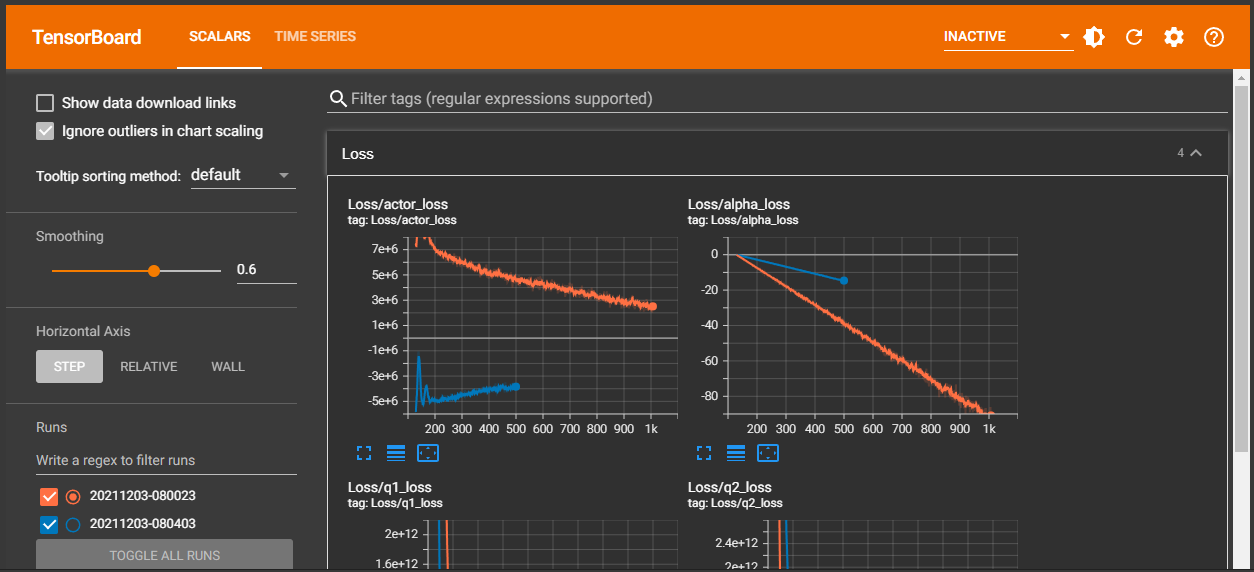

## Packaging deep RL agents for cloud deployments

In [ ]:
%%writefile sac_runtime_components.py
import functools
from collections import deque

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Concatenate, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tf.keras.backend.set_floatx("float64")


def actor(state_shape, action_shape, units=(512, 256, 64)):
    state_shape_flattened = functools.reduce(lambda x, y: x * y, state_shape)
    state = Input(shape=state_shape_flattened)
    x = Dense(units[0], name="L0", activation="relu")(state)
    for index in range(1, len(units)):
        x = Dense(units[index], name="L{}".format(index), activation="relu")(x)

    actions_mean = Dense(action_shape[0], name="Out_mean")(x)
    actions_std = Dense(action_shape[0], name="Out_std")(x)

    model = Model(inputs=state, outputs=[actions_mean, actions_std])

    return model


def critic(state_shape, action_shape, units=(512, 256, 64)):
    state_shape_flattened = functools.reduce(lambda x, y: x * y, state_shape)
    inputs = [Input(shape=state_shape_flattened), Input(shape=action_shape)]
    concat = Concatenate(axis=-1)(inputs)
    x = Dense(units[0], name="Hidden0", activation="relu")(concat)
    for index in range(1, len(units)):
        x = Dense(units[index], name="Hidden{}".format(index), activation="relu")(x)

    output = Dense(1, name="Out_QVal")(x)
    model = Model(inputs=inputs, outputs=output)

    return model


def update_target_weights(model, target_model, tau=0.005):
    weights = model.get_weights()
    target_weights = target_model.get_weights()
    for i in range(len(target_weights)):  # set tau% of target model to be new weights
        target_weights[i] = weights[i] * tau + target_weights[i] * (1 - tau)
    target_model.set_weights(target_weights)


class SAC(object):
    def __init__(
        self,
        observation_shape,
        action_space,
        lr_actor=3e-5,
        lr_critic=3e-4,
        actor_units=(64, 64),
        critic_units=(64, 64),
        auto_alpha=True,
        alpha=0.2,
        tau=0.005,
        gamma=0.99,
        batch_size=128,
        memory_cap=100000,
    ):
        self.state_shape = observation_shape  # shape of observations
        self.action_shape = action_space.shape  # number of actions
        self.action_bound = (action_space.high - action_space.low) / 2
        self.action_shift = (action_space.high + action_space.low) / 2
        self.memory = deque(maxlen=int(memory_cap))

        # Define and initialize actor network
        self.actor = actor(self.state_shape, self.action_shape, actor_units)
        self.actor_optimizer = Adam(learning_rate=lr_actor)
        self.log_std_min = -20
        self.log_std_max = 2
        print(self.actor.summary())

        # Define and initialize critic networks
        self.critic_1 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_target_1 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_optimizer_1 = Adam(learning_rate=lr_critic)
        update_target_weights(self.critic_1, self.critic_target_1, tau=1.0)

        self.critic_2 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_target_2 = critic(self.state_shape, self.action_shape, critic_units)
        self.critic_optimizer_2 = Adam(learning_rate=lr_critic)
        update_target_weights(self.critic_2, self.critic_target_2, tau=1.0)

        print(self.critic_1.summary())

        # Define and initialize temperature alpha and target entropy
        self.auto_alpha = auto_alpha
        if auto_alpha:
            self.target_entropy = -np.prod(self.action_shape)
            self.log_alpha = tf.Variable(0.0, dtype=tf.float64)
            self.alpha = tf.Variable(0.0, dtype=tf.float64)
            self.alpha.assign(tf.exp(self.log_alpha))
            self.alpha_optimizer = Adam(learning_rate=lr_actor)
        else:
            self.alpha = tf.Variable(alpha, dtype=tf.float64)

        # Set hyperparameters
        self.gamma = gamma  # discount factor
        self.tau = tau  # target model update
        self.batch_size = batch_size

        # Tensorboard
        self.summaries = {}

    def process_actions(self, mean, log_std, test=False, eps=1e-6):
        std = tf.math.exp(log_std)
        raw_actions = mean

        if not test:
            raw_actions += tf.random.normal(shape=mean.shape, dtype=tf.float64) * std

        log_prob_u = tfp.distributions.Normal(loc=mean, scale=std).log_prob(raw_actions)
        actions = tf.math.tanh(raw_actions)

        log_prob = tf.reduce_sum(log_prob_u - tf.math.log(1 - actions ** 2 + eps))

        actions = actions * self.action_bound + self.action_shift

        return actions, log_prob

    def act(self, state, test=False, use_random=False):
        state = state.reshape(-1)  # Flatten state
        state = np.expand_dims(state, axis=0).astype(np.float64)

        if use_random:
            a = tf.random.uniform(
                shape=(1, self.action_shape[0]), minval=-1, maxval=1, dtype=tf.float64
            )
        else:
            means, log_stds = self.actor.predict(state)
            log_stds = tf.clip_by_value(log_stds, self.log_std_min, self.log_std_max)

            a, log_prob = self.process_actions(means, log_stds, test=test)

        q1 = self.critic_1.predict([state, a])[0][0]
        q2 = self.critic_2.predict([state, a])[0][0]
        self.summaries["q_min"] = tf.math.minimum(q1, q2)
        self.summaries["q_mean"] = np.mean([q1, q2])

        return a

    def load_actor(self, a_fn):
        self.actor.load_weights(a_fn)
        print(self.actor.summary())

    def load_critic(self, c_fn):
        self.critic_1.load_weights(c_fn)
        self.critic_target_1.load_weights(c_fn)
        self.critic_2.load_weights(c_fn)
        self.critic_target_2.load_weights(c_fn)
        print(self.critic_1.summary())

In [ ]:
%%writefile trading_agent.py
import os
import sys
from argparse import ArgumentParser

import gym.spaces
from flask import Flask, request
import numpy as np

from sac_runtime_components import SAC


parser = ArgumentParser(
    prog="TFRL-Packaging-RL-Agents-For-Cloud-Deployments"
)

parser.add_argument("--agent", default="SAC", help="Name of Agent. Default=SAC")
parser.add_argument(
    "--host-ip",
    default="0.0.0.0",
    help="IP Address of the host server where Agent service is run. Default=127.0.0.1",
)
parser.add_argument(
    "--host-port",
    default="5555",
    help="Port on the host server to use for Agent service. Default=5555",
)
parser.add_argument(
    "--trained-models-dir",
    default="/content",
    help="Directory contained trained models. Default=content",
)
parser.add_argument(
    "--config",
    default="runtime_config.json",
    help="Runtime config parameters for the Agent. Default=runtime_config.json",
)
parser.add_argument(
    "--observation-shape",
    default=(6, 31),
    help="Shape of observations. Default=(6, 31)",
)
parser.add_argument(
    "--action-space-low", default=[-1], help="Low value of action space. Default=[-1]"
)
parser.add_argument(
    "--action-space-high", default=[1], help="High value of action space. Default=[1]"
)
parser.add_argument(
    "--action-shape", default=(1,), help="Shape of actions. Default=(1,)"
)
parser.add_argument(
    "--model-version",
    default="final_episode_StockTradingContinuousEnv-v0",
    help="Trained model version",
)
args = parser.parse_args()


if __name__ == "__main__":
    if args.agent != "SAC":
        print(f"Unsupported Agent: {args.agent}. Using SAC Agent")
        args.agent = "SAC"
    # Set Agent's runtime configs
    observation_shape = args.observation_shape
    action_space = gym.spaces.Box(
        np.array(args.action_space_low),
        np.array(args.action_space_high),
        args.action_shape,
    )

    # Create an instance of the Agent
    agent = SAC(observation_shape, action_space)
    # Load trained Agent model/brain
    model_version = args.model_version
    agent.load_actor(
        os.path.join(args.trained_models_dir, f"sac_actor_{model_version}.h5")
    )
    agent.load_critic(
        os.path.join(args.trained_models_dir, f"sac_critic_{model_version}.h5")
    )
    print(f"Loaded {args.agent} agent with trained model version:{model_version}")

    # Setup Agent (http) service
    app = Flask(__name__)

    @app.route("/v1/act", methods=["POST"])
    def get_action():
        data = request.get_json()
        action = agent.act(np.array(data.get("observation")), test=True)
        return {"action": action.numpy().tolist()}

    # Launch/Run the Agent (http) service
    app.run(host=args.host_ip, port=args.host_port, debug=True)

Writing trading_agent.py


In [ ]:
!sudo nohup python trading_agent.py > log_trading_agent.txt 2>&1 &

In [ ]:
!head log_trading_agent.txt

2021-12-03 08:29:23.726443: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 186)]        0           []                               
                                                                                                  
 L0 (Dense)                     (None, 64)           11968       ['input_1[0][0]']                
                                                                                                  
 L1 (Dense)                     (None, 64)           4160        ['L0[0][0]']                     


## Simple test for the deployed Trading Bot-as-a-Service

In [ ]:
import os
import sys

import gym
import requests

import tradegym  # Register tradegym envs with OpenAI Gym registry

host_ip = "127.0.0.1"
host_port = 5555
endpoint = "v1/act"
env = gym.make("StockTradingContinuousEnv-v0")

post_data = {"observation": env.observation_space.sample().tolist()}
res = requests.post(f"http://{host_ip}:{host_port}/{endpoint}", json=post_data)
if res.ok:
    print(f"Received Agent action:{res.json()}")

Received Agent action:{'action': [[0.2692909986143388]]}


---

In [ ]:
!apt-get -qq install tree
!rm -r sample_data

Selecting previously unselected package tree.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!tree -h --du .

.
├── [924K]  logs
│   └── [920K]  TFRL-SAC
│       ├── [623K]  20211203-080023
│       │   └── [619K]  events.out.tfevents.1638518423.fe9c99dc08cc.645.0.v2
│       └── [293K]  20211203-080403
│           └── [289K]  events.out.tfevents.1638518643.fe9c99dc08cc.645.1.v2
├── [8.1K]  log_trading_agent.txt
├── [141K]  log.txt
├── [8.9K]  __pycache__
│   └── [4.9K]  sac_runtime_components.cpython-37.pyc
├── [148K]  sac_actor_final_episode_StockTradingContinuousEnv-v0.h5
├── [146K]  sac_critic_final_episode_StockTradingContinuousEnv-v0.h5
├── [5.8K]  sac_runtime_components.py
├── [ 83K]  tradegym
│   ├── [7.3K]  crypto_trading_env.py
│   ├── [ 41K]  data
│   │   ├── [ 19K]  MSFT.csv
│   │   └── [ 18K]  TSLA.csv
│   ├── [ 775]  __init__.py
│   ├── [ 14K]  __pycache__
│   │   ├── [ 685]  __init__.cpython-37.pyc
│   │   ├── [4.3K]  stock_trading_continuous_env.cpython-37.pyc
│   │   └── [5.4K]  trading_utils.cpython-37.pyc
│   ├── [7.1K]  stock_trading_continuous_env.py
│   └── [8.2K]  trading_

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p numpy,tensorflow,flask

Author: Sparsh A.

Last updated: 2021-12-03 08:37:44

numpy     : 1.19.5
tensorflow: 2.7.0
flask     : 2.0.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

gym     : 0.17.3
sys     : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
IPython : 5.5.0
requests: 2.23.0



---

**END**